### Подчиняются ли реальные графы каким-либо законам?

Загрузка графа

In [1]:
import json
full_friends = json.load(open("nodes.txt", "tr"))
full_graph = json.load(open("edges.txt", "tr"))
import networkx as nx
G = nx.Graph()
for i in full_friends["items"]:
    G.add_node(i["id"], name = i["first_name"]+" "+i["last_name"], sex = i["sex"])
my_friends = list(nx.nodes(G))
for i in my_friends:
    if "items" in full_graph[str(i)]:
        for j in full_graph[str(i)]["items"]:
            if j in my_friends:
                G.add_edge(i, j)
                


Посмотрим на распределение степеней в моем графе друзей в VK:

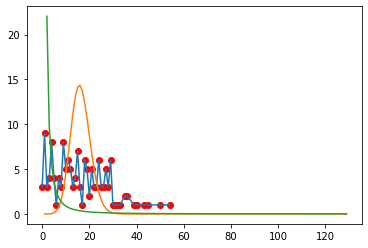

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import collections
from scipy.special import factorial, zeta


degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
mean_degree = np.mean(degree_sequence)
cnt = len(degree_sequence)
t = np.arange(1, 130, 1)
poiss = cnt*np.exp(-mean_degree)*np.power(mean_degree, t)/factorial(t)
l=2.0
power = cnt*np.power(t, -l)/zeta(l)


degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
plt.plot(deg, cnt, "ro")
plt.plot(deg, cnt)
plt.plot(t,poiss)
plt.plot(t[1:], power[1:])
plt.show()

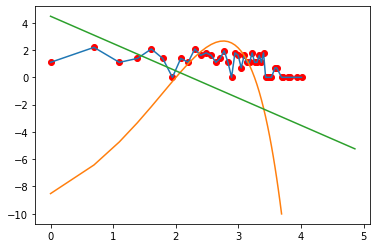

In [3]:
from math import log
deg_l = [log(x+1) for x in deg]
cnt_l = [log(x) for x in cnt]

poiss_l = [log(x) for x in poiss]
power_l = [log(x) for x in power]
t_l = [log(x) for x in t]


plt.plot(deg_l, cnt_l, "ro")
plt.plot(deg_l, cnt_l)
plt.plot(t_l[:40], poiss_l[:40])
plt.plot(t_l, power_l)
plt.show()

И так мы видим, что распределение не совсем пуассоновское, как следовало бы ожидать при случайном графе. Но при этом мы не видим и так называемого Power Law. Power law это предположение что распределение степеней вершин пропорционально $k^{-\lambda}$.

Вместе с тем, глядя на логарифмический график, мы хорошо видим, что крупные хабы очень сильно выбиваются из пуассоновского распределения, и немного меньше из Power law.

Графы, распределение вершин в которых ведет себя как степенное распределение, мы будем называть scale-free (безмасштабная сеть или масштабно-инвариантная сеть).

Главная особенность степенного распределения заключается в том, что при $\lambda < 3$ дисперсия становится бесконечной, а это приводит к возможности <<черных лебедей>>. То есть существование ютуб канала T-Series с 160+ млн. подписчиков или PewDiePie c 107 это вполне соответствует модели.

На самом деле сейчас периодически возникают споры, насколько все же реальные сети соответствуют степенному закону распределения степеней вершин. Но очень часто это оказывается достаточно хорошим и разумным предположением.

Следует понимать, что часто эффект от такого предположения будет достигаться на достаточно больших сетях.


В попытках объяснить формирование реальных scale-free сетей и объяснить наличие крупных хабов или центров притяжения была предпринята попытка изучить не только сам результат и текущее состояние сети, но и ее эволюцию. Почему сеть становится именно такой. Что к этому приводит?

Одна из идей заключается в понимании, что в обычной случайной сети у ребра нет предпочтений. И у узла тоже нет. Ему все равно к чему присоединиться, лишь бы обеспечить себе необходимое число связей.

Например, если у нас задано распределение степеней, то мы можем генерировать граф с заданным распределением по простой схеме. На каждом шаге выбираем две вершины (в некоторых моделях не обязательно разные) с вероятностью пропорциональной <<еще не обеспеченной степени вершины>>. 

Но что делать если мы не знаем истинных степеней вершин, но хотим обеспечить похожую генерацю графа? Ну мы можем предположить, что <<необеспеченная степень>> сравнима с уже собранной. То есть новые ребра (исходящие преимущественно из новых узлов) будут выбирать уже существующие узлы пропорционально их степени. Такой процесс называется *предпочтительное присоединение* (Preferential Attachment).

Крупные хабы становятся <<известными>> и их известность привлекает новых соседей.


А вот краткая история по версии Барабаси:
![](http://networksciencebook.com/images/ch-05/figure-5-2.jpg)




### Mодель Барабаси-Альберт

Формально: 

Путь уже есть сеть с $n$ узлами со степенями $k_i$.
Тогда новый узел прикрепляется к $i$-тому узлу с вероятностью $\frac{k_i}{\sum k_i}$. В некоторых обобщениях узел может присоединяться и к самому себе и к узлам с которыми он уже соединен. Это происходит если число новых связей у новоого узла больше одной.

In [8]:
def plot_graph(g, coloring = [], palette = plt.cm.Set2):
    with plt.xkcd():
        k = nx.degree(g)
#         plt.figure(1, figsize=(30,30))
        coord = nx.kamada_kawai_layout(g)
        if len(coloring)>0:
            nx.draw_networkx(g, pos=coord, nodelist=[x[0] for x in k], node_size=[v[1]*50 for v in k],
            font_size=17, node_color=coloring, cmap=palette)
        else:
            nx.draw_networkx(g, pos=coord, nodelist=[x[0] for x in k], node_size=[v[1]*50 for v in k],
            font_size=17)

In [16]:
from numpy.random import choice

def grow_graph(m=3, N=150):
    G_base = nx.complete_graph(m*2)
    print('Исходный граф:')
    plot_graph(G_base)
    for step in range(2*m, N):
        deg = list(nx.degree(G_base))
        # добавляем новый узел 
        G_base.add_node(step)
        v_id, cnt = zip(*deg)
        # прикрепляем к i-му узлу по вероятности 
        v_to_add = choice(v_id, m, p=np.array(cnt)/sum(cnt), replace=False)
        for v in v_to_add:
            G_base.add_edge(step, v)
    return G_base

Исходный граф:


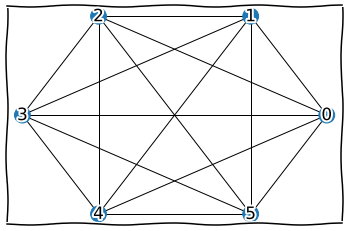

In [17]:
G = grow_graph(m=3, N=20)

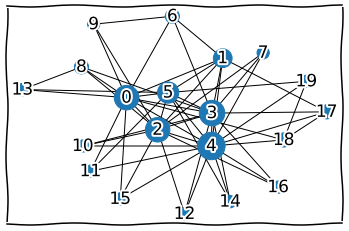

In [18]:
('Итоговый граф:')
plot_graph(G)